In [3]:
from functools import reduce, partial
import inspect

from pyquaternion import Quaternion 
from sklearn.metrics import mean_squared_error

from pylab import *
import pandas as pd

np.random.seed=1
%matplotlib inline

import pixiedust

import warnings
warnings.filterwarnings("ignore")

from Utilities import *

Pixiedust database opened successfully


In [4]:
path1 = 'C:/Users/talaa/PycharmProjects/rl/src/2017_10_26_00_55_52.csv'
dataset = pd.read_csv(path1, skiprows=range(1, 100))
length, width = dataset.shape

## data is collected at 10 Hz

In [5]:
X, y = getInputOutputVelocityModel(dataset, limit=length, frequency=10.0)

In [6]:
X.head()

,dXB,dYB,dZB,dPsi,dTheta,dPhi,Psi,Theta,moveForward,yawCCW,yawCW,hover
0,0.743953,-0.000005,0.459517,1.250167e-08,0.289567,3.357095e-08,1.643317e-09,-0.294853,1.0,0.0,0.0,0.0
1,1.032476,-0.000007,0.558390,-2.376070e-09,0.250486,3.279071e-08,1.405710e-09,-0.269805,1.0,0.0,0.0,0.0
2,1.313352,-0.000009,0.612646,-3.231714e-08,0.234233,3.758810e-08,-1.826004e-09,-0.246381,1.0,0.0,0.0,0.0
3,1.580046,-0.000010,0.633264,2.209636e-08,0.210405,3.141655e-08,3.836320e-10,-0.225341,1.0,0.0,0.0,0.0
4,1.772718,-0.000011,0.607898,1.038605e-08,0.201931,3.138338e-08,1.422237e-09,-0.205148,1.0,0.0,0.0,0.0


In [7]:
y.head()

,dXB,dYB,dZB,dPsi,dTheta,dPhi
0,1.032476,-0.000007,0.558390,-2.376070e-09,0.250486,3.279071e-08
1,1.313352,-0.000009,0.612646,-3.231714e-08,0.234233,3.758810e-08
2,1.580046,-0.000010,0.633264,2.209636e-08,0.210405,3.141655e-08
3,1.772718,-0.000011,0.607898,1.038605e-08,0.201931,3.138338e-08
4,2.053686,-0.000013,0.600896,6.833371e-09,0.185892,3.335636e-08


In [8]:
limit = 8000
integration_error = np.zeros((limit, 6))

## Sanity Check (Velocity)

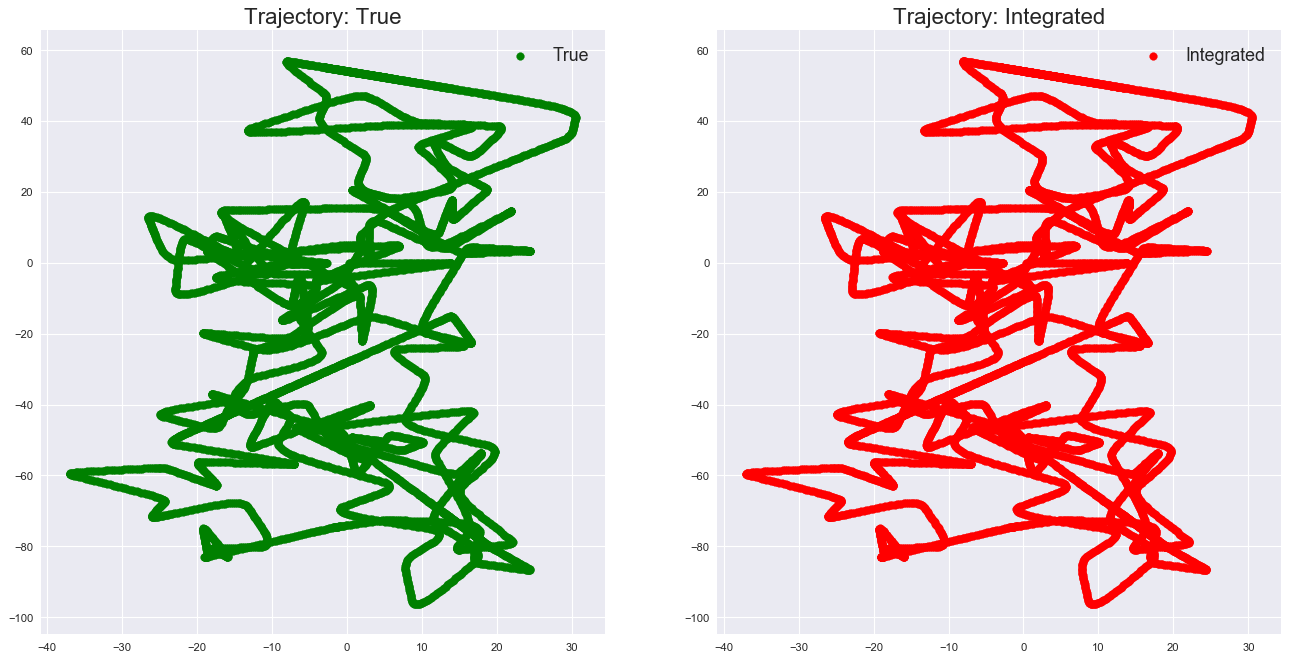

In [9]:
gen1 = integrateTrajectoryVelocityBody(initialPosition=dataset.loc[1, ['x', 'y', 'z']].values,
                                       initialOrientation=dataset.loc[1, ['psi', 'theta', 'phi']].values,
                                       linearVelocitiesBody=y[['dXB', 'dYB', 'dZB']].values,
                                       angularVelocities=y[['dPsi', 'dTheta', 'dPhi']].values,
                                       frequency=10.0 * np.ones((limit, )))

figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

for i in range(2, limit):
    p, o = next(gen1)
    
    subplot(1, 2, 1)
    legend(['True'], fontsize=16)
    title('Trajectory: True', fontdict={'fontsize':20})
    
    pTrue = dataset.loc[i, ['x', 'y', 'z']]
    oTrue = dataset.loc[i, ['psi', 'theta', 'phi']]
    plt.scatter(pTrue[0], pTrue[1], color='green')
    
    subplot(1, 2, 2)
    legend(['Integrated'], fontsize=16)
    title('Trajectory: Integrated', fontdict={'fontsize':20})
    plt.scatter(p[0], p[1], color='red')
    
    assert(np.allclose(p.astype(np.float64), pTrue.astype(np.float64)))
    integration_error[i - 2] = np.concatenate((p.astype(np.float64) - pTrue.astype(np.float64), 
                                               o.astype(np.float64) - oTrue.astype(np.float64)))

In [10]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest =\
train_test_split(X, y, test_size=0.20, random_state=1)

# Velocity Prediction Models

### MLP Regressor (one step)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

cvModel = MLPRegressor(max_iter=int(10e3), random_state=10)
parameters = {'hidden_layer_sizes':[(5, ), (10, ), (15, ), (25, )], 'alpha':[1e-4 * np.exp(i) for i in range(10)]}
clf = GridSearchCV(cvModel, parameters, n_jobs=-1).fit(xTrain, yTrain)

model = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                     alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(xTrain, yTrain)

yPredicted = pd.DataFrame(model.predict(xTest), columns=y.columns)
mean_squared_error(yPredicted['dTheta'], yTest['dTheta']) ** 0.5

0.2761263721726529

In [21]:
model = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                     alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(X, y)

In [22]:
from sklearn.externals import joblib
joblib.dump(model, 'C:/Users/talaa/PycharmProjects/rl/src/neural.model')

['C:/Users/talaa/PycharmProjects/rl/src/neural.model']

### Random Forest (one step)

In [9]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=10, random_state=10).fit(xTrain, yTrain)

In [12]:
yPredicted = pd.DataFrame(model.predict(xTest), columns=y.columns)
mean_squared_error(yPredicted['dTheta'], yTest['dTheta']) ** 0.5

0.2761263721726529

In [13]:
def predict(frequency, initial, limit):
    actions = X[['moveForward', 'yawCCW', 'yawCW', 'hover']].values
    linear_velocities, angular_velocites = np.ones((limit, 3)), np.ones((limit, 3))
    current_orientation = initial[['psi', 'theta', 'psi']].values
    
    for i in range(0, limit):
        if i > 0:
            s0 = np.concatenate((s1, current_orientation[[0, 1]], actions[i]))
        else:
            s0 = X.iloc[0].values
            
        s1 = model.predict(s0.reshape(1, -1))[0]
        current_orientation = integrateOrientation(current_orientation, s1[[3, 4, 5]], frequency)

        linear_velocities[i-1] = s1[[0, 1, 2]]
        angular_velocites[i-1] = s1[[3, 4, 5]]
    
    return linear_velocities, angular_velocites

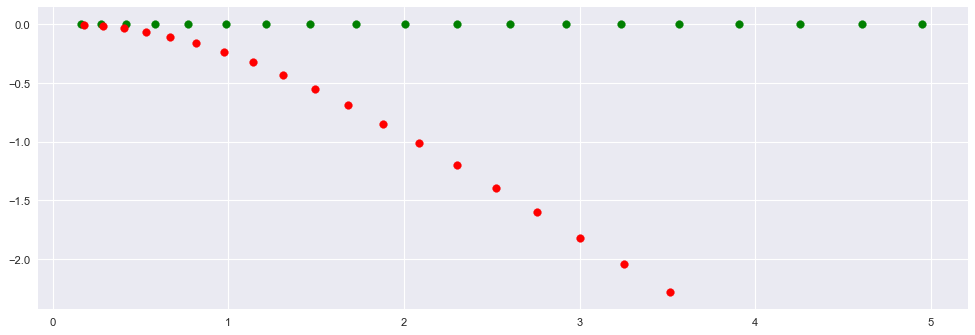

In [14]:
limit = 20
prediction_error = np.zeros((limit, 6))

initial = dataset.iloc[0]
linear_velocities, angular_velocities = predict(10.0, initial, limit)

gen2 = integrateTrajectoryVelocityBody(initialPosition=initial[['x', 'y', 'z']].values,
                                       initialOrientation=initial[['psi', 'theta', 'phi']].values,
                                       linearVelocitiesBody=linear_velocities,
                                       angularVelocities=angular_velocities,
                                       frequency=10.0 * np.ones((limit, )))

figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

for i in range(1, limit):
    p, o = next(gen2)

    pTrue = dataset.loc[i, ['x', 'y', 'z']]
    oTrue = dataset.loc[i, ['psi', 'theta', 'phi']]
    plt.scatter(pTrue[0], pTrue[1], color='green')

    plt.scatter(p[0], p[1], color='red')
    prediction_error[i-1] = np.concatenate((p-pTrue, np.rad2deg(getAverageAngularVelocity(oTrue, o, 1.0))))


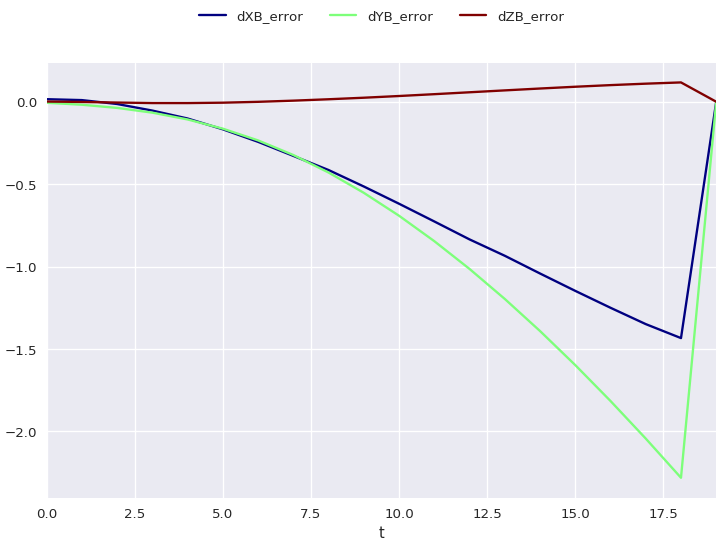

In [15]:
prediction_error_df = pd.DataFrame(prediction_error, columns=['dXB_error', 'dYB_error', 'dZB_error',
                                                              'dPsi_error', 'dTheta_error', 'dPhi_error'])
prediction_error_df['t'] = prediction_error_df.index
display(prediction_error_df)


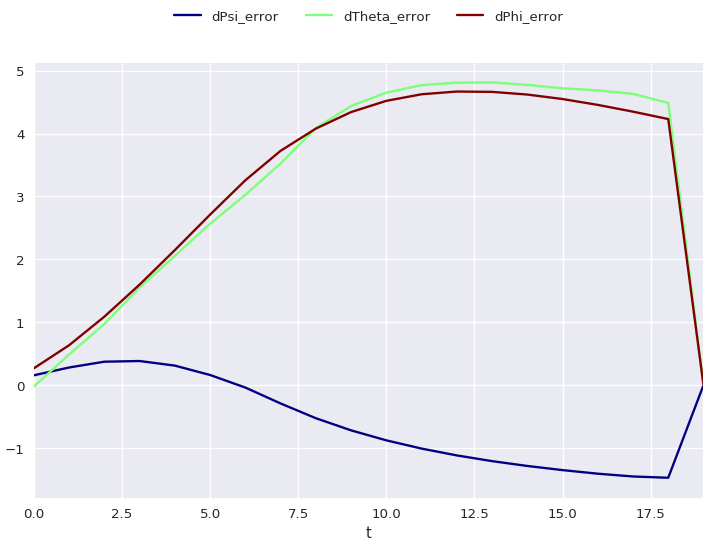

In [16]:
display(prediction_error_df)

In [215]:
from sklearn.externals import joblib
joblib.dump(model, 'C:/Users/talaa/PycharmProjects/rl/src/randomForest.model')

['C:/Users/talaa/PycharmProjects/rl/src/randomForest.model']